## Inception Model
We download Google's inception model and use it to classify some our own images

In [99]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

height=299
width=299
channels=3

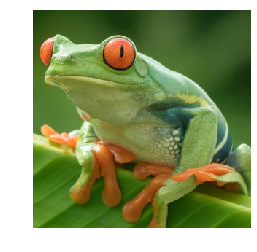

In [108]:
#Clean frog image

frog_im = mpimg.imread("./images/frog.jpg")[:, :, :3]
plt.imshow(frog_im)
plt.axis("off")
plt.show()

#Rescale
frog = (frog_im[:, :, :3] / 255 * 2) - 1

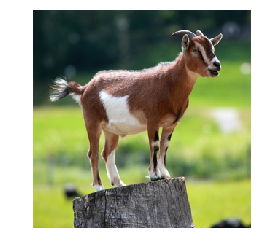

In [109]:
#Clean goat image

goat_im = mpimg.imread("./images/goat.jpg")[:, :, :3]
plt.imshow(goat_im)
plt.axis("off")
plt.show()

#Rescale
goat = (goat_im[:, :, :3] / 255 * 2) - 1

In [72]:
# Helper code for retrieving the model

import sys
import os
import tarfile
from six.moves import urllib

TF_MODELS_URL = "http://download.tensorflow.org/models"
INCEPTION_V3_URL = TF_MODELS_URL + "/inception_v3_2016_08_28.tar.gz"
INCEPTION_PATH = os.path.join("datasets", "inception")
INCEPTION_V3_CHECKPOINT_PATH = os.path.join(INCEPTION_PATH, "inception_v3.ckpt")

def download_progress(count, block_size, total_size):
    percent = count * block_size * 100 // total_size
    sys.stdout.write("\rDownloading: {}%".format(percent))
    sys.stdout.flush()

def fetch_pretrained_inception_v3(url=INCEPTION_V3_URL, path=INCEPTION_PATH):
    if os.path.exists(INCEPTION_V3_CHECKPOINT_PATH):
        return
    os.makedirs(path, exist_ok=True)
    tgz_path = os.path.join(path, "inception_v3.tgz")
    urllib.request.urlretrieve(url, tgz_path, reporthook=download_progress)
    inception_tgz = tarfile.open(tgz_path)
    inception_tgz.extractall(path=path)
    inception_tgz.close()
    os.remove(tgz_path)

In [73]:
# Load the model

fetch_pretrained_inception_v3(url=INCEPTION_V3_URL, path=INCEPTION_PATH)

Downloading: 100%

In [88]:
# Helper class for loading the classes

def load_class_names():
    path = os.path.join("datasets", "inception", "imagenet_class_names.txt")
    with open(path, encoding="utf-8") as f:
        return [line[10:-1] for line in f.readlines()] + ['background']

In [102]:
# Load the classes

class_names = load_class_names()
class_names[:50:4] #Examples

['tench, Tinca tinca',
 'hammerhead, hammerhead shark',
 'hen',
 'house finch, linnet, Carpodacus mexicanus',
 'bulbul',
 'water ouzel, dipper',
 'great grey owl, great gray owl, Strix nebulosa',
 'spotted salamander, Ambystoma maculatum',
 'tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui',
 'terrapin',
 'American chameleon, anole, Anolis carolinensis',
 'alligator lizard',
 'Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis']

In [97]:
# Build graph -- uses special tf helper functions

from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim

tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=[None, 299, 299, 3], name="X")
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(
        X, num_classes=1001, is_training=False)
predictions = end_points["Predictions"]
saver = tf.train.Saver()

In [105]:
# Helper class for making predictions

def make_pred(saver, prediction_obj, class_names, image):
    with tf.Session() as sess:
        saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)
        predictions_val = prediction_obj.eval(feed_dict={X: image.reshape(-1, height, width, channels)})

    top_5 = np.argpartition(predictions_val[0], -5)[-5:]
    top_5 = reversed(top_5[np.argsort(predictions_val[0][top_5])])
    for i in top_5:
        print("{0}: {1:.2f}%".format(class_names[i], 100 * predictions_val[0][i]))

In [110]:
#Frog
make_pred(saver, predictions, class_names, frog)

INFO:tensorflow:Restoring parameters from datasets\inception\inception_v3.ckpt
tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui: 97.76%
loggerhead, loggerhead turtle, Caretta caretta: 1.13%
tree frog, tree-frog: 0.04%
birdhouse: 0.02%
Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis: 0.01%


In [107]:
#Goat
make_pred(saver, predictions, class_names, goat)

INFO:tensorflow:Restoring parameters from datasets\inception\inception_v3.ckpt
hartebeest: 31.33%
Arabian camel, dromedary, Camelus dromedarius: 12.66%
bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis: 5.51%
ibex, Capra ibex: 4.50%
gazelle: 0.92%


Both predictions look pretty good, especially the frog!